## Task 0

### 0.2 Timeseries visualized

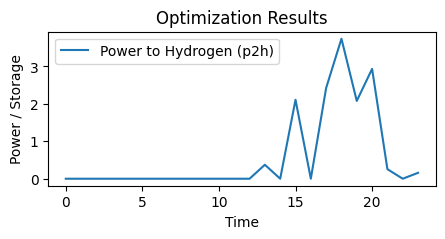

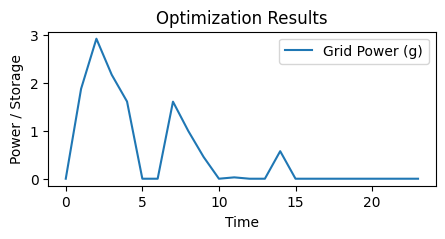

In [3]:

import numpy as np
import matplotlib.pyplot as plt# Extract results
from Task0 import create_model

solver, model, T, p_wind= create_model()
time_series = np.arange(T)
p2h_vals = [model.p2h[t].value for t in model.T]
h2p_vals = [model.h2p[t].value for t in model.T]
g_vals = [model.g[t].value for t in model.T]
s_vals = [model.s[t].value for t in model.T]

# Plot results
plt.figure(figsize=(5, 2))
plt.plot(time_series, p2h_vals, label="Power to Hydrogen (p2h)")
plt.xlabel("Time")
plt.ylabel("Power / Storage")
plt.legend()
plt.title("Optimization Results")
plt.show()

plt.figure(figsize=(5, 2))
plt.plot(time_series, g_vals, label="Grid Power (g)")
plt.xlabel("Time")
plt.ylabel("Power / Storage")
plt.legend()
plt.title("Optimization Results")
plt.show()

The MODEL

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
import WindProcess
import PriceProcess
from data import get_fixed_data
    # Get fixed data
data = get_fixed_data()
T = data['num_timeslots']
D = data['demand_schedule']
P2H = data['p2h_rate']
H2P = data['h2p_rate']
C = data['hydrogen_capacity']
R_p2h = data['conversion_p2h']
R_h2p = data['conversion_h2p']
C_elzr = data['electrolyzer_cost']
# Generate wind and price time series
p_wind = np.random.normal(data['target_mean_wind'], 1, T)
lambda_grid = np.clip(np.random.normal(data['mean_price'], 5, T), data['price_floor'], data['price_cap'])
# Define the optimization model
model = ConcreteModel()
# Sets
model.T = RangeSet(0, T-1)
# Decision Variables
model.x = Var(model.T, within=Binary)
model.p2h = Var(model.T, within=NonNegativeReals)
model.h2p = Var(model.T, within=NonNegativeReals)
model.g = Var(model.T, within=NonNegativeReals)
model.s = Var(model.T, within=NonNegativeReals, bounds=(0, C))
# Objective function: Minimize cost
def objective_rule(model):
    return sum(lambda_grid[t] * model.g[t] + C_elzr * model.x[t] for t in model.T)
model.objective = Objective(rule=objective_rule, sense=minimize)
# Constraints
def power_balance_rule(model, t):
    return D[t] == model.g[t] + p_wind[t] + model.h2p[t] - model.p2h[t]
model.power_balance = Constraint(model.T, rule=power_balance_rule)
def storage_dynamics_rule(model, t):
    if t > 0:
        return model.s[t] == model.s[t-1] + R_p2h * model.p2h[t] - model.h2p[t] / R_h2p
    return Constraint.Skip
model.storage_dynamics = Constraint(model.T, rule=storage_dynamics_rule)
def electrolyzer_operation_rule(model, t):
    return model.p2h[t] <= P2H * model.x[t]
model.electrolyzer_operation = Constraint(model.T, rule=electrolyzer_operation_rule)
def hydrogen_to_power_rule(model, t):
    return model.h2p[t] <= H2P
model.hydrogen_to_power = Constraint(model.T, rule=hydrogen_to_power_rule)
def electrolyzer_switching_rule_lower(model, t):
    if t > 0:
        return -1 <= model.x[t] - model.x[t-1]
    return Constraint.Skip
model.electrolyzer_switching_lower = Constraint(model.T, rule=electrolyzer_switching_rule_lower)
def electrolyzer_switching_rule_upper(model, t):
    if t > 0:
        return model.x[t] - model.x[t-1] <= 1
    return Constraint.Skip
model.electrolyzer_switching_upper = Constraint(model.T, rule=electrolyzer_switching_rule_upper)
# Solve the model
solver = SolverFactory('gurobi')  # Make sure Gurobi is installed and properly configured
solver.solve(model)

{'Problem': [{'Name': 'x1', 'Lower bound': 197.56030351307479, 'Upper bound': 197.56030351307496, 'Number of objectives': 1, 'Number of constraints': 141, 'Number of variables': 120, 'Number of binary variables': 24, 'Number of integer variables': 24, 'Number of continuous variables': 96, 'Number of nonzeros': 328, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.004000186920166016', 'Error rc': 0, 'Time': 0.16575312614440918}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

Power To Hydrogen

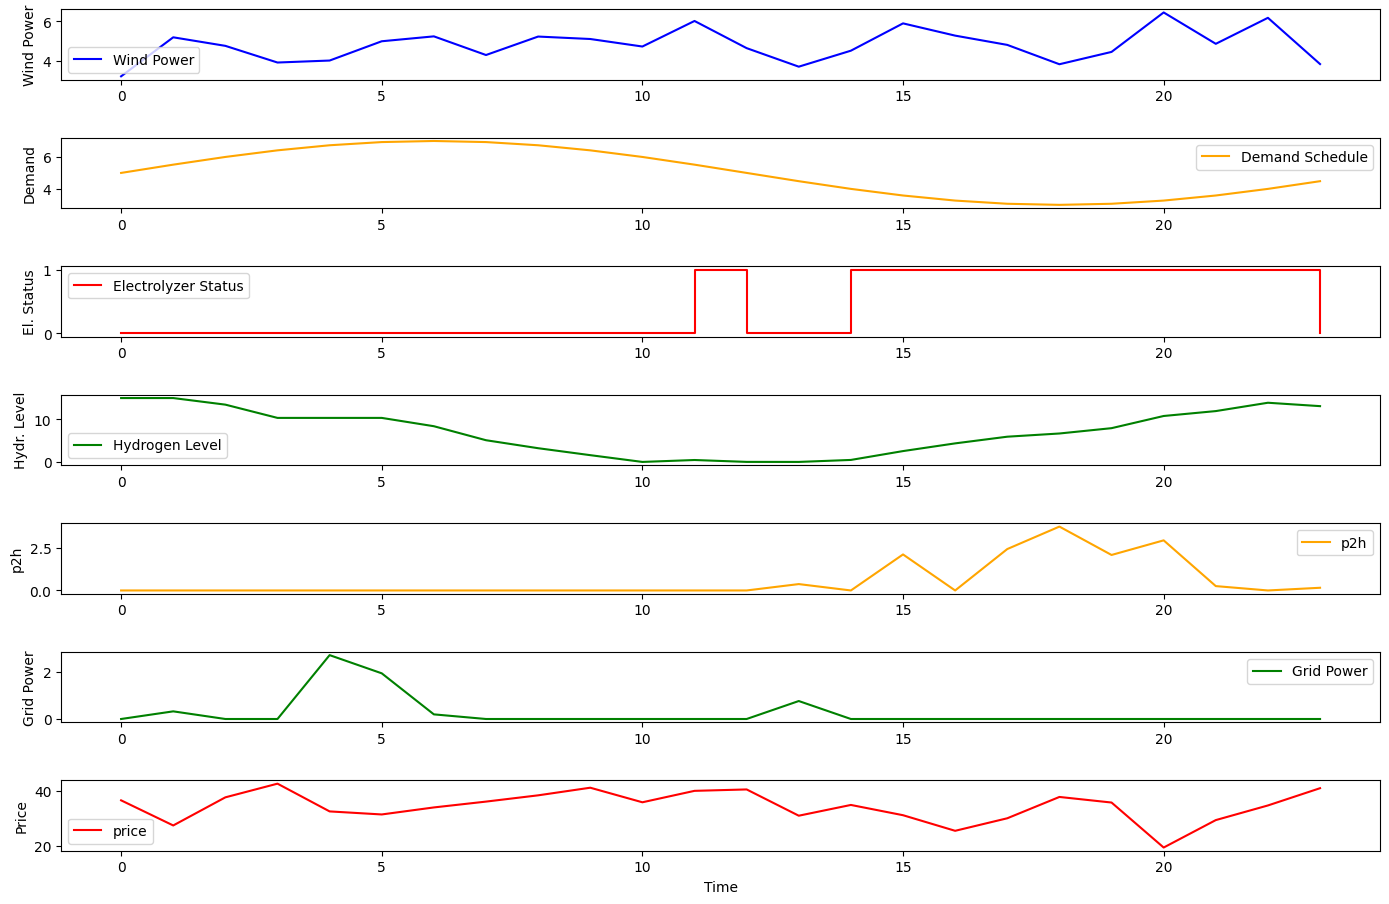

In [13]:

import data
import matplotlib.pyplot as plt

initial_state = {'hydrogen': 0, 'electrolyzer_status': 0}
times = time_series

# Extract hydrogen storage levels into a list
hydrogen_storage_level = [model.s[t].value for t in model.T]
# Extract electrolyzer status into a list (1 for on, 0 for off)
electrolyzer_status = [model.x[t].value for t in model.T]
grid_power = [model.g[t].value for t in model.T]
# Plot results
plt.figure(figsize=(14, 10))

plt.subplot(8, 1, 1)
plt.plot(times, p_wind, label="Wind Power", color="blue")
plt.ylabel("Wind Power")
plt.legend()

plt.subplot(8, 1, 2)
plt.plot(times, D, label="Demand Schedule", color="orange")
plt.ylabel("Demand")
plt.legend()

plt.subplot(8, 1, 3)
plt.step(times, electrolyzer_status, label="Electrolyzer Status", color="red", where="post")
plt.ylabel("El. Status")
plt.legend()

plt.subplot(8, 1, 4)
plt.plot(times, hydrogen_storage_level, label="Hydrogen Level", color="green")
plt.ylabel("Hydr. Level")
plt.legend()

plt.subplot(8, 1, 5)
plt.plot(times, p2h_vals, label="p2h", color="orange")
plt.ylabel("p2h")
plt.legend()


plt.subplot(8, 1, 6)
plt.plot(times, grid_power, label="Grid Power", color="green")
plt.ylabel("Grid Power")
plt.legend()

plt.subplot(8, 1, 7)
plt.plot(times, lambda_grid, label="price", color="red")
plt.ylabel("Price")
plt.xlabel("Time")
plt.legend()

plt.tight_layout()
plt.show()


Hydrogen Storage

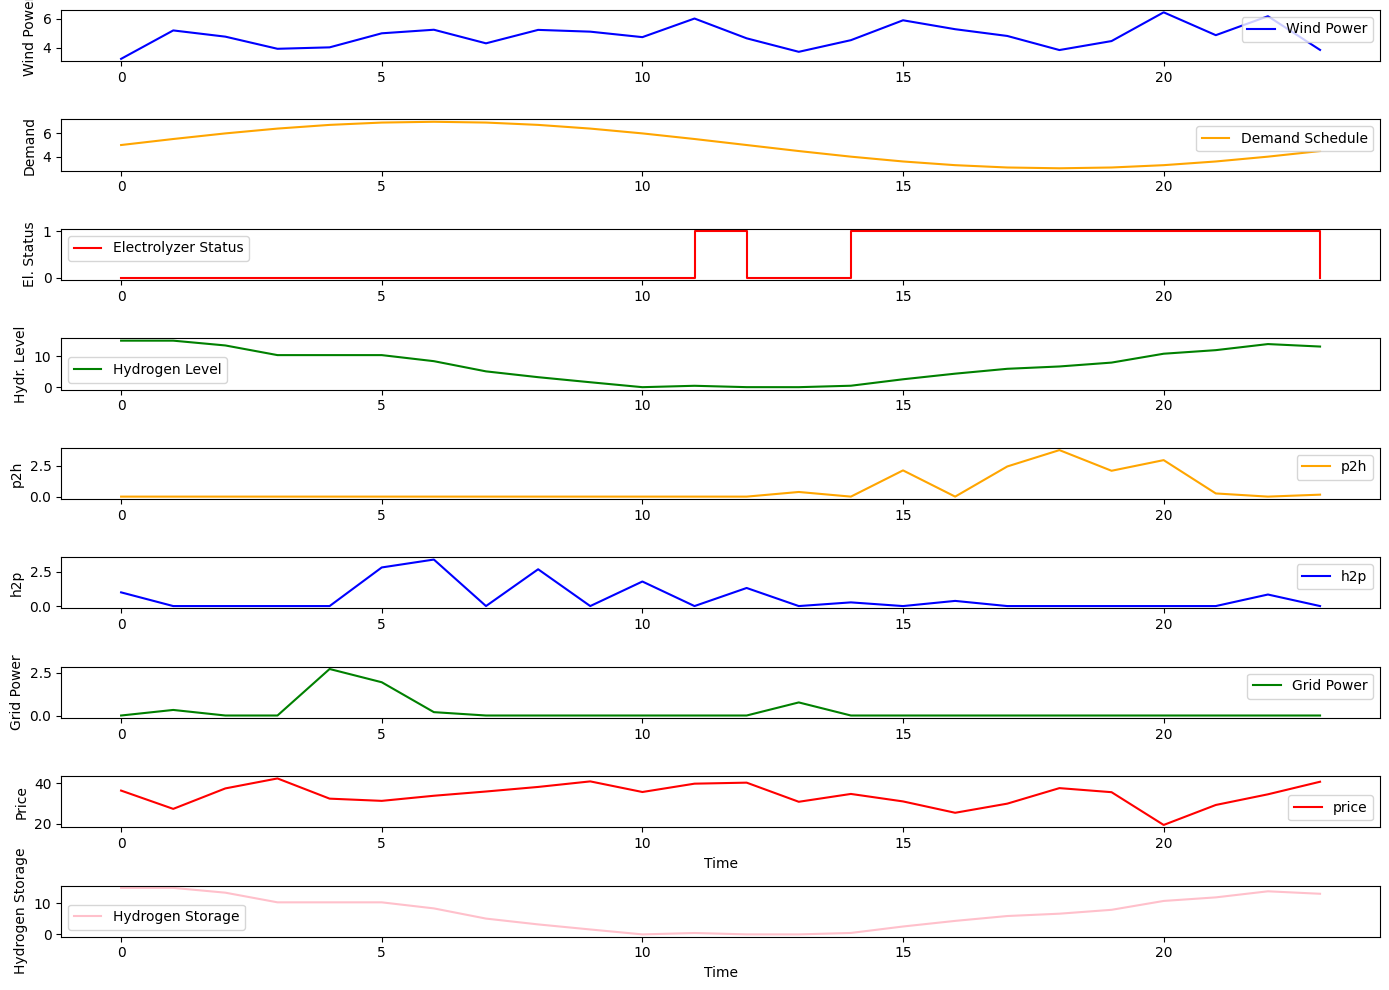

In [12]:

import data
import matplotlib.pyplot as plt

initial_state = {'hydrogen': 0, 'electrolyzer_status': 0}
times = time_series

# Extract hydrogen storage levels into a list
hydrogen_storage_level = [model.s[t].value for t in model.T]
# Extract electrolyzer status into a list (1 for on, 0 for off)
electrolyzer_status = [model.x[t].value for t in model.T]
grid_power = [model.g[t].value for t in model.T]

s_vals = [model.s[t].value for t in model.T]
# Plot results
plt.figure(figsize=(14, 10))

plt.subplot(9, 1, 1)
plt.plot(times, p_wind, label="Wind Power", color="blue")
plt.ylabel("Wind Power")
plt.legend()

plt.subplot(9, 1, 2)
plt.plot(times, D, label="Demand Schedule", color="orange")
plt.ylabel("Demand")
plt.legend()

plt.subplot(9, 1, 3)
plt.step(times, electrolyzer_status, label="Electrolyzer Status", color="red", where="post")
plt.ylabel("El. Status")
plt.legend()

plt.subplot(9, 1, 4)
plt.plot(times, hydrogen_storage_level, label="Hydrogen Level", color="green")
plt.ylabel("Hydr. Level")
plt.legend()

plt.subplot(9, 1, 5)
plt.plot(times, p2h_vals, label="p2h", color="orange")
plt.ylabel("p2h")
plt.legend()

plt.subplot(9, 1, 6)
plt.plot(times, h2p_vals, label="h2p", color="blue")
plt.ylabel("h2p")
plt.legend()


plt.subplot(9, 1, 7)
plt.plot(times, grid_power, label="Grid Power", color="green")
plt.ylabel("Grid Power")
plt.legend()

plt.subplot(9, 1, 8)
plt.plot(times, lambda_grid, label="price", color="red")
plt.ylabel("Price")
plt.xlabel("Time")
plt.legend()


plt.subplot(9, 1, 9)
plt.plot(times, s_vals, label="Hydrogen Storage", color="pink")
plt.ylabel("Hydrogen Storage")
plt.xlabel("Time")
plt.legend()

plt.tight_layout()
plt.show()
